# 0.0 Imports

In [1607]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
from warnings import filterwarnings
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m
from xgboost import XGBClassifier
from imblearn import over_sampling,combine
from category_encoders import OneHotEncoder,TargetEncoder
from lightgbm.sklearn import LGBMClassifier
from boruta import BorutaPy
import pickle as pkl
filterwarnings('ignore')

# 1.0 Collect Data

In [1608]:
dados = pd.read_csv('data/churn.csv')
dados.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [1609]:
print(f'Number of Rows: {dados.shape[0]}\nNumber of Columns: {dados.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


In [1610]:
# Check granuralidade
dados['CustomerId'].unique().shape[0]

10000

# 2.0 Data Cleaning

In [909]:
dados2 = dados.copy()

## 2.1 Drop Irrelevant Features

In [910]:
dados2.drop('RowNumber',1,inplace=True)

## 2.2 Rename Values and Columns

In [911]:
# CamelCase to snake_case

# Columns
for column in dados2.columns:
    dados2.rename(columns={column:inflection.underscore(column)},inplace=True)

# Values
for column in dados2.select_dtypes('object').columns:
    dados2[column] = dados2[column].apply(lambda x: inflection.underscore(x))

## 2.3 Missing Data

In [912]:
dados.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 2.4 Data Dtypes

In [913]:
dados.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

# 3.0 Feature Engineering

In [914]:
dados3 = dados2.copy()

In [917]:
# Surname Size
dados3['surname_size'] = dados3['surname'].apply(lambda x: len(x))

In [921]:
dados3

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,surname_size
0,15634602,hargrave,619,france,female,42,2,0.00,1,1,1,101348.88,1,8
1,15647311,hill,608,spain,female,41,1,83807.86,1,0,1,112542.58,0,4
2,15619304,onio,502,france,female,42,8,159660.80,3,1,0,113931.57,1,4
3,15701354,boni,699,france,female,39,1,0.00,2,0,0,93826.63,0,4
4,15737888,mitchell,850,spain,female,43,2,125510.82,1,1,1,79084.10,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,obijiaku,771,france,male,39,5,0.00,2,1,0,96270.64,0,8
9996,15569892,johnstone,516,france,male,35,10,57369.61,1,1,1,101699.77,0,9
9997,15584532,liu,709,france,female,36,7,0.00,1,0,1,42085.58,1,3
9998,15682355,sabbatini,772,germany,male,42,3,75075.31,2,1,0,92888.52,1,9


# 4.0 Exploratory Data Analysis

In [922]:
dados4 = dados3.copy()

## 4.1 Descriptive Analysis

In [924]:
num_kurt = dados4.kurtosis() # Add kurtosis
num_skewness = dados4.skew() # Add skewness
num_range = dados4.select_dtypes(exclude='object').apply(lambda x: x.max()-x.min()) # Add range
pd.concat([dados4.describe().T,num_kurt,num_skewness,num_range],axis=1).rename(columns={0:'kurtosis',1:'skewness',2:'range'}).drop('count',1)[1:]

,mean,std,min,25%,50%,75%,max,kurtosis,skewness,range
credit_score,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,-0.425726,-0.071607,500.00
age,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,1.395347,1.011320,74.00
tenure,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00,-1.165225,0.010991,10.00
balance,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,-1.489412,-0.141109,250898.09
num_of_products,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,0.582981,0.745568,3.00
has_cr_card,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00,-1.186973,-0.901812,1.00
is_active_member,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00,-1.996747,-0.060437,1.00
estimated_salary,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,-1.181518,0.002085,199980.90
exited,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00,0.165671,1.471611,1.00
surname_size,6.455300,2.289001,2.00,5.00,6.000,8.0000,23.00,1.361349,0.609321,21.00


In [925]:
dados4.select_dtypes('object').describe().T

,count,unique,top,freq
surname,10000,2932,smith,32
geography,10000,3,france,5014
gender,10000,2,male,5457


## 4.2 Univariate Analysis

### 4.2.1 Target Variable

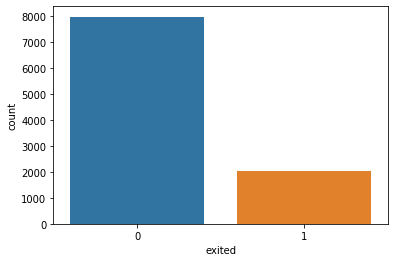

In [926]:
sns.countplot(dados4['exited']);

In [927]:
(dados4['exited'].value_counts(normalize=True)*100).round(2)

0    79.63
1    20.37
Name: exited, dtype: float64

### 4.2.2 Histograms

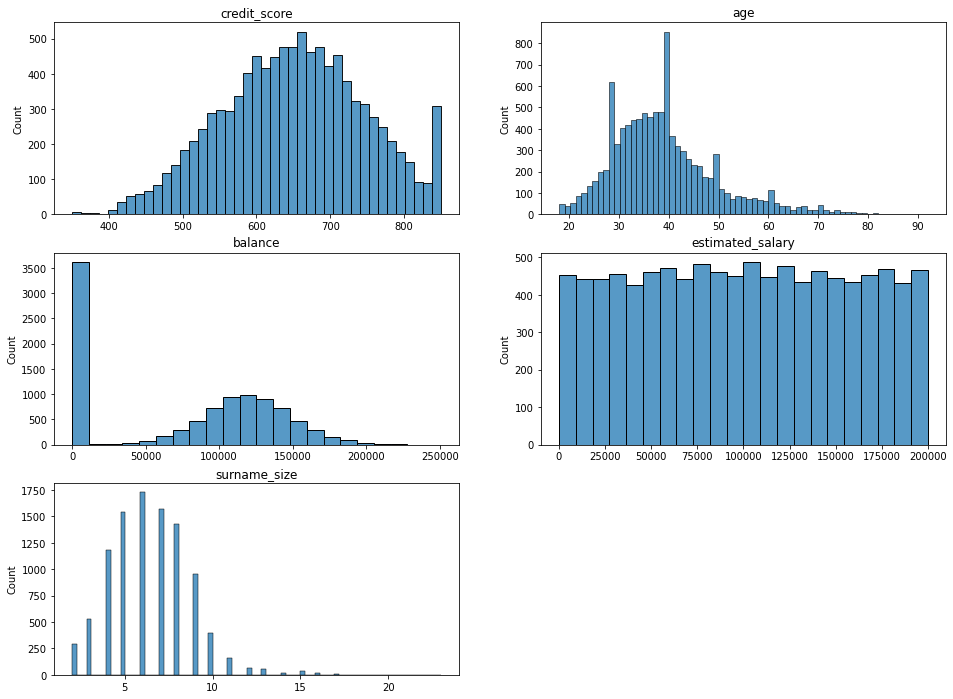

In [929]:
features_aux = ['credit_score','age','balance','estimated_salary','surname_size']
plt.figure(figsize=(16,12))
for n, feature in enumerate(features_aux):
    plt.subplot(3,2,n+1)
    ax = sns.histplot(dados4[feature])
    ax.set_title(feature,fontsize=12)
    ax.set_xlabel('')

### 4.2.3 Countplot

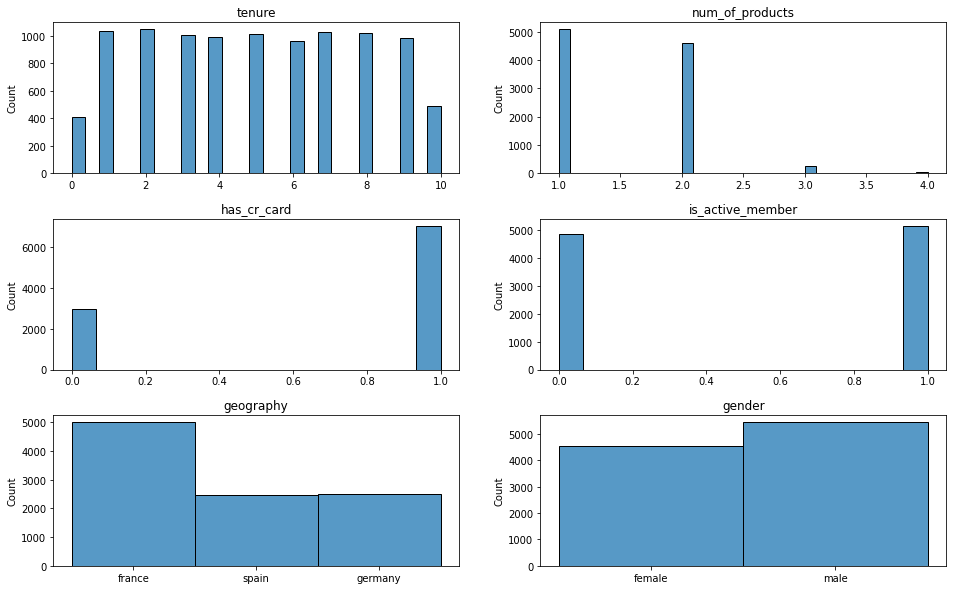

In [930]:
features_aux = ['tenure','num_of_products','has_cr_card','is_active_member','geography','gender']
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.3)
for n, feature in enumerate(features_aux):
    plt.subplot(3,2,n+1)
    ax = sns.histplot(dados4[feature])
    ax.set_title(feature,fontsize=12)
    ax.set_xlabel('')

## 4.3 Bivariate Analysis

### H1: Se é um membro ativo tem menor chance de churn (Verificar data leakeage)

This hypothesis is **TRUE**
Não vemos data leakage, o que vemos é que os clientes que não são ativos tem maiores chances de churn, o que é bem razoável. A dúvida que ainda resta é: se o cliente é ativo, por que ele entraria em churn?

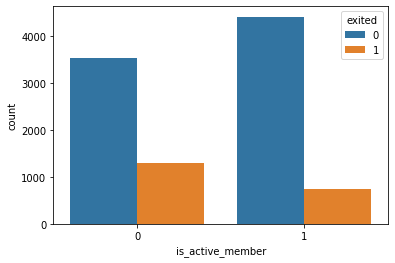

In [931]:
sns.countplot(dados4['is_active_member'],hue=dados4['exited']);

In [932]:
(pd.crosstab(dados4['is_active_member'],dados4['exited'],normalize=0)*100).round(2)

exited,0,1
is_active_member,,
0,73.15,26.85
1,85.73,14.27


### H2: Clientes que tiveram um maior tempo ativo tem menor chance de churn

This hypothesis is **FALSE**

Essa feature aparentemente não nos diz muita coisa, ela não separa tão bem os dados em nossas classes, ao menos em princípio.

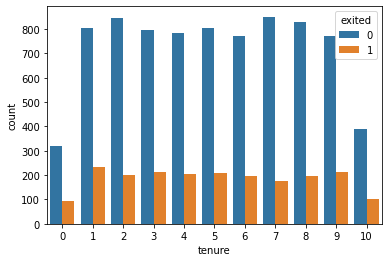

In [933]:
sns.countplot(dados4['tenure'],hue=dados4['exited']);

In [934]:
(pd.crosstab(dados4['tenure'],dados4['exited'],normalize=0)*100).round(2)

exited,0,1
tenure,,
0,77.00,23.00
1,77.58,22.42
2,80.82,19.18
3,78.89,21.11
4,79.47,20.53
5,79.35,20.65
6,79.73,20.27
7,82.78,17.22
8,80.78,19.22


### H3: Existe uma diferença de gênero nas estatísticas de churn

This hypothesis is **TRUE**

Vemos claramente que as mulheres costumam dar churn muito mais do que os homens.

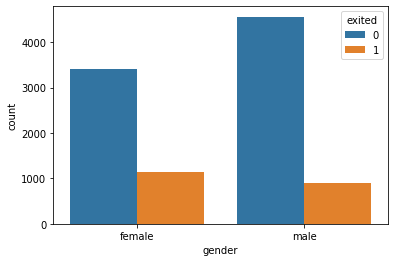

In [935]:
sns.countplot(dados4['gender'],hue=dados4['exited']);

In [936]:
(pd.crosstab(dados4['gender'],dados4['exited'],normalize=0)*100).round(2)

exited,0,1
gender,,
female,74.93,25.07
male,83.54,16.46


### H4: Clientes mais velhos são menos propensos a churn

This hypothesis is **FALSE**

Se vermos a distribuição de quem deu churn e quem não deu, vemos que em quem deu a idade é mais avançada do que em quem continua a consumir o produto da empresa.

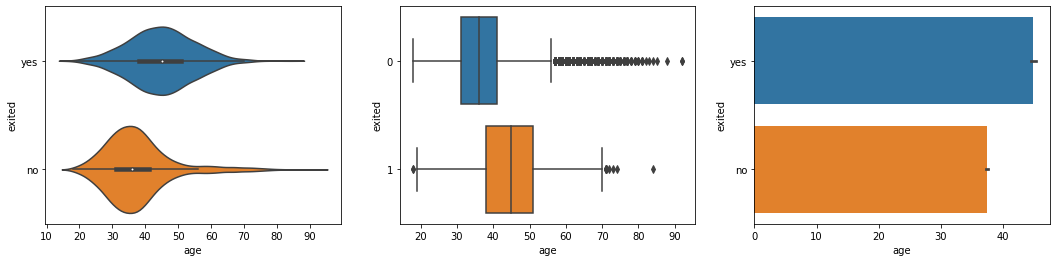

In [937]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
sns.violinplot(dados4['age'],dados4['exited'].map({0:'no',1:'yes'}))

plt.subplot(1,3,2)
sns.boxplot(y=dados4['exited'],x=dados4['age'],orient='h')

plt.subplot(1,3,3)
sns.barplot(y=dados4['exited'].map({0:'no',1:'yes'}),x=dados4['age'])

plt.show()

### H5: Clientes com maiores estimate salaries tem menor propensão de churn

This hypothesis is **FALSE**

Não vemos diferença entre as distribuições, essa feature parece não separar bem nossas classes, ao menos em princípio.

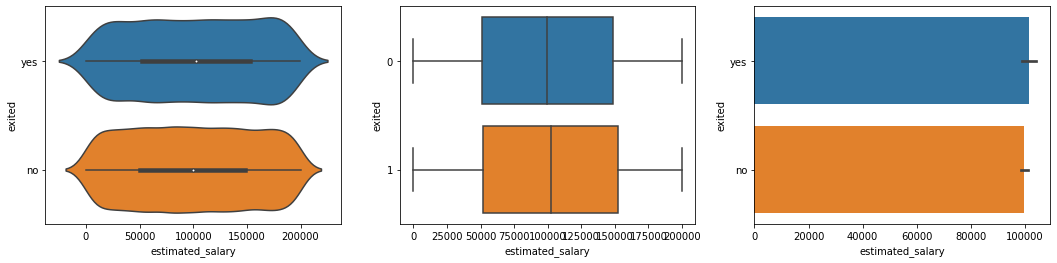

In [938]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
sns.violinplot(dados4['estimated_salary'],dados4['exited'].map({0:'no',1:'yes'}))

plt.subplot(1,3,2)
sns.boxplot(y=dados4['exited'],x=dados4['estimated_salary'],orient='h')

plt.subplot(1,3,3)
sns.barplot(y=dados4['exited'].map({0:'no',1:'yes'}),x=dados4['estimated_salary'])

plt.show()

## 4.4 Multivariate Analysis

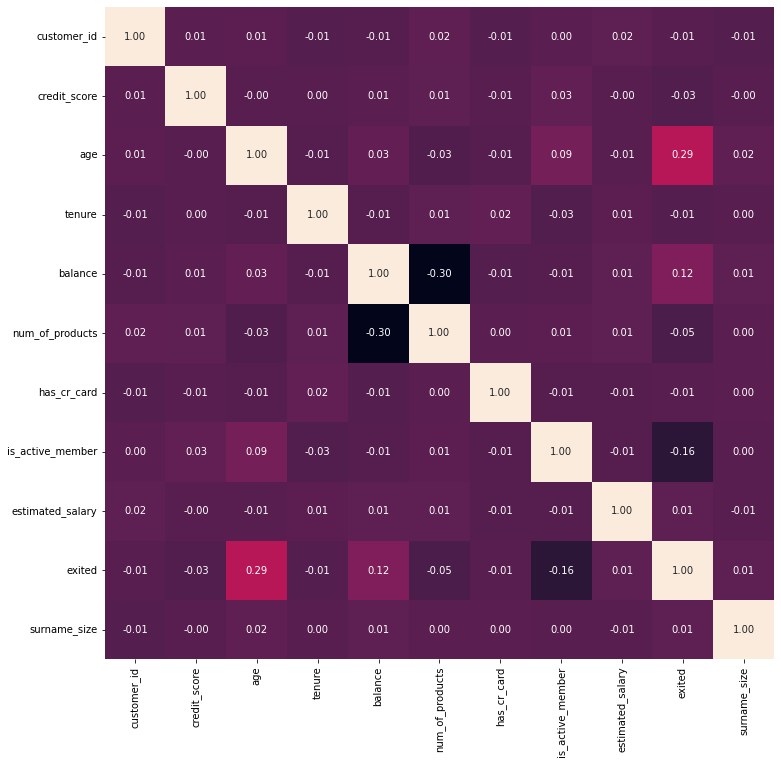

In [939]:
plt.figure(figsize=(12,12))
sns.heatmap(dados4.corr(),annot=True,fmt='.2f',cbar=False);

# 5.0 Data Filtering

In [1616]:
dados5 = dados4.copy()

In [1617]:
dados5.drop(['customer_id','surname'],1,inplace=True) # Por agora vou tirar essas colunas 'inúteis'
# Tenho perspectiva de fazer algo com surname, talvez indique um movimento familiar ou de origem

# 6.0 Data Preparation

In [1618]:
dados6 = dados5.copy()

## 6.1 Train Test Split

In [1619]:
x , y = dados6.drop('exited',1),dados6['exited']
x_train_val,x_test,y_train_val,y_test = train_test_split(x,y,test_size=0.1,random_state=101,stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=101,stratify=y_train_val)

## 6.2 Encoding

In [1620]:
te = TargetEncoder(cols=['geography'])

te.fit(x_train,y_train)
x_train = te.transform(x_train)
x_val = te.transform(x_val)
x_test = te.transform(x_test)
pkl.dump(te,open('/Users/nando/Comunidade DS/churn/deploy/pkl/te.pkl','wb'))

le = LabelEncoder()
le.fit(x_train['gender'])
x_train['gender'] = le.transform(x_train['gender'])
x_val['gender'] = le.transform(x_val['gender'])
x_test['gender'] = le.transform(x_test['gender'])
pkl.dump(le,open('/Users/nando/Comunidade DS/churn/deploy/pkl/le.pkl','wb'))

## 6.3 Oversampling

In [1621]:
over_sampler = over_sampling.SMOTE()
x_train,y_train = over_sampler.fit_resample(x_train,y_train)
x_train = pd.DataFrame(x_train)

## 6.4 Rescaling

In [1622]:
mms = MinMaxScaler()
columns = ['credit_score', 'geography', 'gender', 'age','tenure', 'balance', 'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'surname_size']

mms.fit(x_train)
x_train = mms.transform(x_train)
x_val = mms.transform(x_val)
x_test = mms.transform(x_test)

x_train = pd.DataFrame(x_train,columns=columns)
x_val = pd.DataFrame(x_val,columns=columns)
x_test = pd.DataFrame(x_test,columns=columns)

pkl.dump(mms,open('/Users/nando/Comunidade DS/churn/deploy/pkl/mms.pkl','wb'))

## 6.5 Feature Selection

In [1623]:
x_train.columns[boruta.support_]

Index(['credit_score', 'geography', 'gender', 'age', 'balance',
       'num_of_products', 'is_active_member', 'estimated_salary'],
      dtype='object')

In [1624]:
estimator = RandomForestClassifier(n_jobs=-1)
boruta = BorutaPy(estimator, n_estimators='auto', verbose=2, random_state=101)
boruta.fit(x_train.values, y_train.values)
print(f'\n\nSelected Features:\n {list(x_train.columns[boruta.support_].values)}')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


Selected Features:
 ['credit_score', 'geography', 'gender', 'age', 'balance', 'num_of_products', 'is_active_member', 'estimated_salary']


In [1625]:
cols = ['credit_score', 'geography', 'gender', 'age', 'balance', 'num_of_products', 'is_active_member', 'estimated_salary']
x_train = x_train[cols]
x_val = x_val[cols]
x_test = x_test[cols]

# 7.0 Model Selection and Evaluation

## 7.1 Hold-Out

### 7.1.1 Decision Tree

In [1626]:
model = DecisionTreeClassifier()
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84      1433
           1       0.44      0.59      0.50       367

    accuracy                           0.76      1800
   macro avg       0.66      0.70      0.67      1800
weighted avg       0.79      0.76      0.77      1800



### 7.1.2 Logistic Regression

In [1627]:
model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82      1433
           1       0.40      0.58      0.47       367

    accuracy                           0.74      1800
   macro avg       0.64      0.68      0.65      1800
weighted avg       0.78      0.74      0.75      1800



### 7.1.3 Random Forest

In [1628]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1433
           1       0.58      0.59      0.59       367

    accuracy                           0.83      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.83      0.83      0.83      1800



### 7.1.4 SVM

In [1629]:
model = SVC()
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1433
           1       0.53      0.58      0.55       367

    accuracy                           0.81      1800
   macro avg       0.71      0.72      0.71      1800
weighted avg       0.82      0.81      0.81      1800



### 7.1.5 XGBoost

In [1630]:
model = XGBClassifier()
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1433
           1       0.62      0.61      0.61       367

    accuracy                           0.84      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.84      0.84      0.84      1800



### 7.1.6 LGBM

In [1631]:
model = LGBMClassifier()
model.fit(x_train,y_train)
print(classification_report(y_val,model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1433
           1       0.62      0.63      0.62       367

    accuracy                           0.85      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.85      0.85      0.85      1800



## 7.2 Cross Validation

In [1633]:
def pipeline_datapreparation(x_train,y_train,x_val,y_val):
    
    ## 6.2 Encoding

    te = TargetEncoder(cols=['geography'])
    te.fit(x_train,y_train)
    x_train = te.transform(x_train)
    x_val = te.transform(x_val)

    le = LabelEncoder()
    le.fit(x_train['gender'])
    x_train['gender'] = le.transform(x_train['gender'])
    x_val['gender'] = le.transform(x_val['gender'])

    ## 6.3 Oversampling

    over_sampler = over_sampling.SMOTE()
    x_train,y_train = over_sampler.fit_resample(x_train,y_train)
    x_train = pd.DataFrame(x_train)

    ## 6.4 Rescaling

    mms = MinMaxScaler()
    columns = ['credit_score', 'geography', 'gender', 'age','tenure', 'balance', 'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'surname_size']

    mms.fit(x_train)
    x_train = mms.transform(x_train)
    x_val = mms.transform(x_val)
    x_train = pd.DataFrame(x_train,columns=columns)
    x_val = pd.DataFrame(x_val,columns=columns)
    
    ## 6.5 Feature Selection
    
    cols = ['credit_score', 'geography', 'gender', 'age', 'balance', 'num_of_products', 'is_active_member', 'estimated_salary']
    x_train = x_train[cols]
    x_val = x_val[cols]
    
    return x_train,y_train,x_val,y_val

In [1634]:
def cv(model,x,y,cv_spliter):
    accuracy, precision, recall, f1 = [],[],[],[]
    for fold, (train_index, val_index) in enumerate(cv_spliter.split(x,y)):
        x_train, x_val, y_train, y_val = x.loc[train_index],x.loc[val_index],y.loc[train_index],y.loc[val_index]
        
        print(f'{fold+1}º Fold da CV!')
        
        x_train,y_train,x_val,y_val = pipeline_datapreparation(x_train,y_train,x_val,y_val)

        model.fit(x_train,y_train)

        y_true = y_val
        y_pred = model.predict(x_val)
        
        precision.append(m.precision_score(y_true,y_pred))
        recall.append(m.recall_score(y_true,y_pred))
        f1.append(m.f1_score(y_true,y_pred))
        accuracy.append(m.accuracy_score(y_true,y_pred))
        
    print('\nAccuracy: {:.3f} +/- {:.3f}\nPrecision: {:.3f} +/- {:.3f}\nRecall: {:.3f} +/- {:.3f}\nF1 Score: {:.3f} +/- {:.3f}'.format(np.mean(accuracy),np.std(accuracy),np.mean(precision),np.std(precision),np.mean(recall),np.std(recall),np.mean(f1),np.std(f1)))

### 7.2.1 Decision Tree

In [1635]:
cv(DecisionTreeClassifier(),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.779 +/- 0.004
Precision: 0.465 +/- 0.011
Recall: 0.583 +/- 0.010
F1 Score: 0.518 +/- 0.009


### 7.2.2 Logistic Regression

In [1636]:
cv(LogisticRegression(),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.734 +/- 0.011
Precision: 0.399 +/- 0.018
Recall: 0.605 +/- 0.024
F1 Score: 0.481 +/- 0.021


### 7.2.3 Random Forest

In [1637]:
cv(RandomForestClassifier(n_jobs=-1),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.833 +/- 0.005
Precision: 0.588 +/- 0.024
Recall: 0.607 +/- 0.027
F1 Score: 0.597 +/- 0.024


### 7.2.4 SVM

In [1638]:
cv(SVC(),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.809 +/- 0.006
Precision: 0.526 +/- 0.018
Recall: 0.619 +/- 0.028
F1 Score: 0.569 +/- 0.022


### 7.2.5 XGBoost

In [1639]:
cv(XGBClassifier(),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.840 +/- 0.004
Precision: 0.604 +/- 0.020
Recall: 0.626 +/- 0.018
F1 Score: 0.615 +/- 0.017


### 7.2.6 LGBM

In [1640]:
cv(LGBMClassifier(n_jobs=-1),x,y,KFold(n_splits=5))

1º Fold da CV!
2º Fold da CV!
3º Fold da CV!
4º Fold da CV!
5º Fold da CV!

Accuracy: 0.842 +/- 0.008
Precision: 0.611 +/- 0.030
Recall: 0.617 +/- 0.025
F1 Score: 0.614 +/- 0.025


# 8.0 Hyperparams Fine Tuning

In [1641]:
# best model (ill do hyperparams fine tuning later)
model = LGBMClassifier().fit(x_train,y_train)
pkl.dump(model,open('/Users/nando/Comunidade DS/churn/deploy/pkl/model.pkl','wb'))

# 9.0 Error and Business Interpretation

## 9.1 Error Interpretation

In [1387]:
# Precision Top 100
lgbm = LGBMClassifier()
lgbm.fit(x_train,y_train)
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       796
           1       0.59      0.58      0.59       204

    accuracy                           0.83      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.83      0.83      0.83      1000



## 9.2 Business Interpretation

In [1475]:
# A possível perda é de: 1% do balance (transações)
# Custa 0.5% do balance fazer o cliente desistir do churn (Quanto mais dinheiro a pessoa tem, mais caro ela custa)

### 9.2.1 Approaches Comparison

Using AI -> Max ROI: $22582.232 com o investimento em 114 clientes


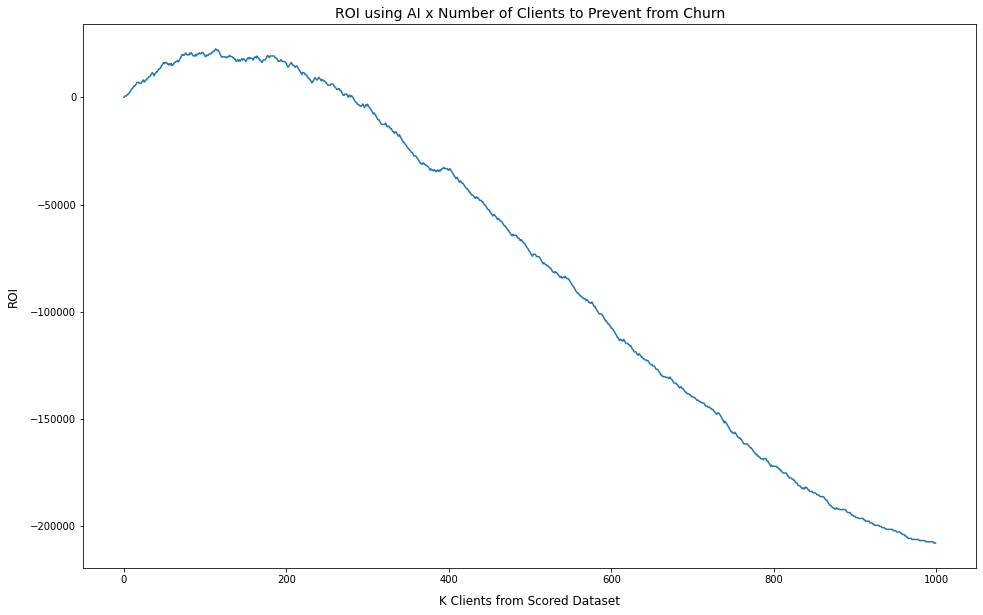

In [1486]:
# Using AI

aux = pd.DataFrame()
aux['y_true'] = y_true
aux['y_proba'] = y_proba[:,1]
aux['balance'] = dados5.loc[aux.index,'balance']
aux['possivel_perda'] = aux['balance']*0.01
aux['custo'] = aux['balance']*0.005
aux = aux.sort_values('y_proba',ascending=False)

roi_ai,k_list = [],np.arange(0,aux.shape[0])
for k in k_list:
    aux_k = aux[:k] # scored choice
    y1 = aux_k[aux_k['y_true']==1]
    y0 = aux_k[aux_k['y_true']==0]
    possivel_perda = y1['possivel_perda'].sum()
    custo = y1['custo'].sum()+y0['custo'].sum()
    roi_ai.append(possivel_perda - custo)
    
print(f'Using AI -> Max ROI: ${np.max(roi_ai).round(3)} com o investimento em {roi_ai.index(np.max(roi_ai))+1} clientes')

plt.figure(figsize=(16,10))
ax = sns.lineplot(x=k_list,y=roi_ai);
ax.set_title('ROI using AI x Number of Clients to Prevent from Churn',size=14)
ax.set_ylabel('ROI',labelpad=10,size=12)
ax.set_xlabel('K Clients from Scored Dataset',labelpad=10,size=12)
plt.show()

Not Using Ai -> Max ROI: $0.005 com o investimento em 5 clientes


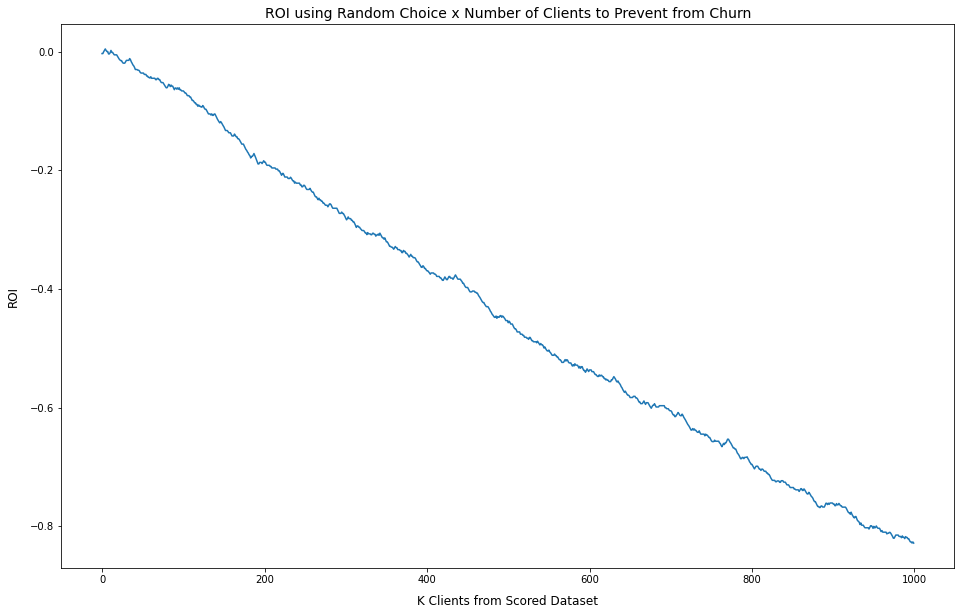

In [1485]:
# Not using AI

aux = x_test
aux['exited'] = np.array(y_test)

roi_random,k_list = [],np.arange(0,aux.shape[0])
for k in k_list:
    aux_k = aux.sample(k+1,random_state=101) # random choice
    aux_k['possivel_perda'] = aux_k['balance']*0.01
    aux_k['custo'] = aux_k['balance']*0.005
    y1 = aux_k[aux_k['exited']==1]
    y0 = aux_k[aux_k['exited']==0]
    possivel_perda = y1['possivel_perda'].sum()
    custo = y1['custo'].sum()+y0['custo'].sum()
    roi_random.append(possivel_perda - custo)
    
print(f'Not Using Ai -> Max ROI: ${np.max(roi_random).round(3)} com o investimento em {roi_random.index(np.max(roi_random))+1} clientes')

plt.figure(figsize=(16,10))
ax = sns.lineplot(x=k_list,y=roi_random);
ax.set_title('ROI using Random Choice x Number of Clients to Prevent from Churn',size=14)
ax.set_ylabel('ROI',labelpad=10,size=12)
ax.set_xlabel('K Clients from Scored Dataset',labelpad=10,size=12)
plt.show()

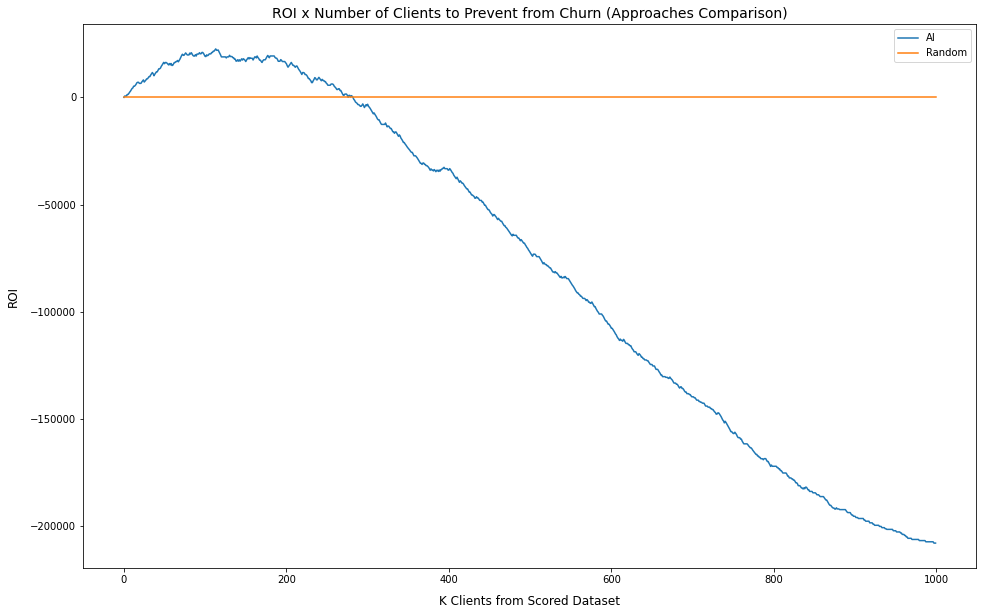

In [1484]:
plt.figure(figsize=(16,10))

# Using AI
ax = sns.lineplot(x=k_list,y=roi_ai,label='AI')

# Not using AI
ax = sns.lineplot(x=k_list,y=roi_random,label='Random')

ax.set_title('ROI x Number of Clients to Prevent from Churn (Approaches Comparison)',size=14)
ax.set_ylabel('ROI',labelpad=10,size=12)
ax.set_xlabel('K Clients from Scored Dataset',labelpad=10,size=12)

plt.legend()
plt.show()

### 9.2.2 Tomada de decisão

In [ ]:
# Fornecer uma faixa de valores para ter um ROI esperado se utilizar AI

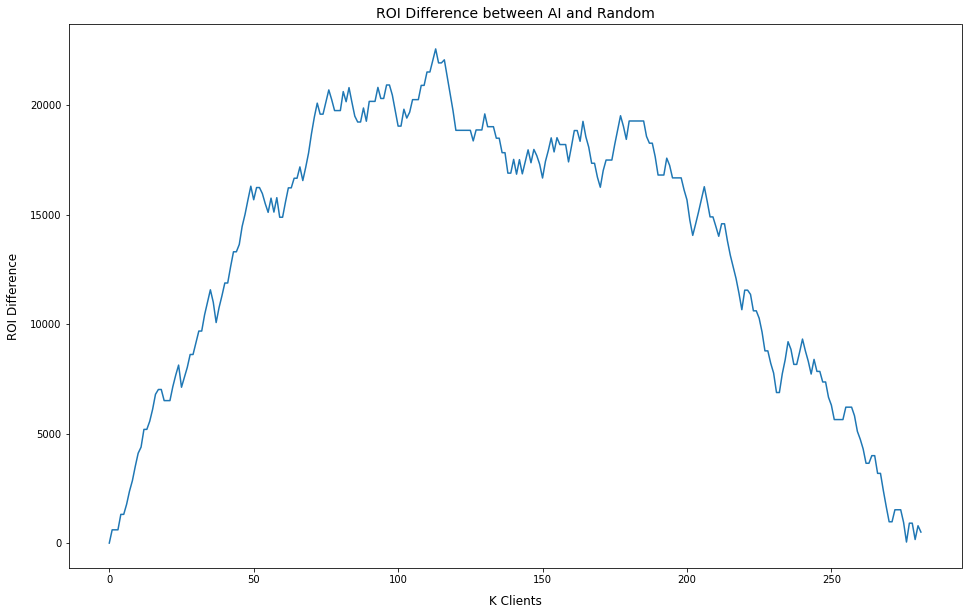

In [1540]:
# Vou aproximar o gráfico na parte em que a AI é melhor que o random para escolher a faixa de valores!
diff = []
for c in range(len(roi_ai)):
    diff.append(roi_ai[c]-roi_random[c])

plt.figure(figsize=(16,10))
aux = pd.DataFrame([diff,k_list]).T.rename(columns={0:'diff',1:'k'})
aux = aux[aux['diff']>0]
ax = sns.lineplot(y=aux['diff'],x=aux['k'])
ax.set_title('ROI Difference between AI and Random',size=14)
ax.set_ylabel('ROI Difference',labelpad=10,size=12)
ax.set_xlabel('K Clients',labelpad=10,size=12)
plt.show()

Vou determinar a faixa de 50 à 150 clientes como margem de segurança para obter o maior ROI.

In [1543]:
# Roi Esperado usando AI
aux[(aux['k']>=50)&(aux['k']<=150)]['diff'].describe()[1:]

mean    18810.662197
std      1865.969449
min     14890.564584
25%     17380.308241
50%     19027.328495
75%     20184.432219
max     22582.315643
Name: diff, dtype: float64

## 10.0 Model Deploy

## 10.1 Churn Class

In [1578]:
import pandas as pd
import pickle as pkl
import inflection

class Churn():
    def __init__(self):
        self.le = pkl.load(open('/Users/nando/Comunidade DS/churn/deploy/pkl/le.pkl','rb'))
        self.te = pkl.load(open('/Users/nando/Comunidade DS/churn/deploy/pkl/te.pkl','rb'))
        self.mms = pkl.load(open('/Users/nando/Comunidade DS/churn/deploy/pkl/mms.pkl','rb'))
        
    def data_cleaning(self,dados):

        ## 2.1 Drop Irrelevant Features

        dados.drop('RowNumber',1,inplace=True)

        ## 2.2 Rename Values and Columns

        # CamelCase to snake_case

        # Columns
        for column in dados.columns:
            dados.rename(columns={column:inflection.underscore(column)},inplace=True)

        # Values
        for column in dados.select_dtypes('object').columns:
            dados[column] = dados[column].apply(lambda x: inflection.underscore(x))
        
        return dados
    
    def feature_engineering(self,dados):
    
        # Surname Size
        dados['surname_size'] = dados['surname'].apply(lambda x: len(x))
    
        return dados
    
    def data_filtering(self,dados):
        dados.drop(['customer_id','surname'],1,inplace=True)
        return dados
    
    def data_preparation(self,dados):

        ## 6.2 Encoding
        dados = self.te.transform(dados)
        dados['gender'] = self.le.transform(dados['gender'])

        ## 6.4 Rescaling
        columns = ['credit_score', 'geography', 'gender', 'age','tenure', 'balance', 'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'surname_size']
        dados = self.mms.transform(dados)
        dados = pd.DataFrame(dados,columns=columns)

        ## 6.5 Feature Selection
        cols = ['credit_score', 'geography', 'gender', 'age', 'balance', 'num_of_products', 'is_active_member','estimated_salary']
        dados = dados[cols]
        
        return dados
    
    def get_predictions(self,model,dados):
        return_data = dados.copy()
        return_data['predictions'] = model.predict(dados)
        return_data['predictions_proba'] = model.predict_proba(dados)[:,1]
        return_data = return_data.sort_values('predictions_proba',ascending=False)
        return return_data.to_json()

## 10.2 Handler.py

In [ ]:
from flask import Flask,request,Response
from churn import Churn
import os
import pickle as pkl
import pandas as pd

app = Flask(__name__)
@app.route('/predict',methods=['POST'])

def predict():
    model = pkl.load(open('/Users/nando/Comunidade DS/churn/deploy/pkl/model.pkl','rb'))
    json = request.get_json()
    if json:
        dados = pd.DataFrame(json)
        dados = Churn().data_cleaning(dados)
        dados = Churn().feature_engineering(dados)
        dados = Churn().data_filtering(dados)
        dados = Churn().data_preparation(dados)
        return Churn().get_predictions(model,dados)
    else:
        return Response('{}',status=200)

if __name__ == '__main__':
    app.run(host='0.0.0.0',port=os.environ.get('PORT',8080),debug=False)

## 10.3 API Request Test

### 10.3.1 Local Request

In [1652]:
import requests
dados = pd.read_csv('data/churn.csv')
dados = dados.sample(1000).drop('Exited',1)
dados = dados.to_json()

json = requests.post(url='http://0.0.0.0:8080/predict',data=dados,headers={'Content-type':'application/json'})
print('Response:',json.status_code)
pd.DataFrame(json.json())

Response: 200


,credit_score,geography,gender,age,balance,num_of_products,is_active_member,estimated_salary,predictions,predictions_proba
605,0.560,1.000000,0.0,0.445946,0.432244,0.666667,0.0,0.441659,1,0.994873
495,0.968,1.000000,0.0,0.527027,0.447519,0.666667,0.0,0.701084,1,0.994583
877,0.710,1.000000,0.0,0.621622,0.611680,0.666667,0.0,0.732847,1,0.992447
120,0.732,0.000000,0.0,0.459459,0.262942,0.333333,0.0,0.072604,1,0.987995
667,0.664,0.069403,0.0,0.540541,0.000000,0.000000,0.0,0.880251,1,0.984529
...,...,...,...,...,...,...,...,...,...,...
105,0.848,0.000000,1.0,0.783784,0.448433,0.000000,1.0,0.715634,0,0.007657
414,0.288,0.000000,1.0,0.094595,0.000000,0.333333,1.0,0.549804,0,0.007367
397,0.318,0.000000,1.0,0.108108,0.000000,0.333333,1.0,0.030427,0,0.007326
454,1.000,0.000000,0.0,0.851351,0.000000,0.333333,1.0,0.297547,0,0.003571


### 10.3.2 Cloud Request

In [1660]:
import requests
dados = pd.read_csv('data/churn.csv')
dados = dados.sample(1000).drop('Exited',1)
dados = dados.to_json()

json = requests.post(url='https://churn-predict-cds.herokuapp.com/predict',data=dados,headers={'Content-type':'application/json'})
print('Response:',json.status_code)
pd.DataFrame(json.json())

Response: 200


,credit_score,geography,gender,age,balance,num_of_products,is_active_member,estimated_salary,predictions,predictions_proba
590,0.754,1.000000,1.0,0.378378,0.459342,1.000000,0.0,0.653689,1,0.994384
911,0.394,1.000000,1.0,0.500000,0.443857,0.666667,0.0,0.084183,1,0.994291
383,0.400,1.000000,1.0,0.418919,0.433670,0.666667,0.0,0.306946,1,0.992294
801,0.710,1.000000,0.0,0.486486,0.501755,0.666667,0.0,0.479887,1,0.990191
889,0.814,0.069403,0.0,0.500000,0.467497,1.000000,0.0,0.470751,1,0.988446
...,...,...,...,...,...,...,...,...,...,...
547,0.810,0.000000,0.0,0.810811,0.483092,0.000000,1.0,0.379840,0,0.009575
133,0.812,0.000000,1.0,0.121622,0.000000,0.333333,1.0,0.789678,0,0.008580
934,0.510,1.000000,1.0,0.770270,0.244401,0.000000,1.0,0.933380,0,0.007622
534,0.858,0.000000,1.0,0.716216,0.000000,0.333333,1.0,0.734456,0,0.006720
